In [21]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [22]:
import numpy as np
import pandas as pd
import fastai
from fastcore.all import *
import os
from fastbook import *
from fastai.vision.widgets import *


In [23]:
key = os.environ.get('AZURE_SEARCH_KEY')

In [24]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [25]:
big_cats = 'tiger', 'jaguar','leopard','lion','tiger'
path = Path('big_cats')

In [26]:
if not path.exists():
    path.mkdir()
    for o in big_cats:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} animal')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [27]:
fns = get_image_files(path)
fns

(#3730) [Path('big_cats/cheetah/011c7ffc-8533-4166-aa30-b95f5b1c3884.jpg'),Path('big_cats/cheetah/0238989e-1c32-4529-b438-1bcf0d6419e5.jpg'),Path('big_cats/cheetah/04c7c77a-2e80-458b-8d50-23034aee5b89.jpg'),Path('big_cats/cheetah/09f51628-4674-468f-8662-fb2f94db5652.jpg'),Path('big_cats/cheetah/0cfc61de-7287-4ef9-bc47-98af670d2809.jpg'),Path('big_cats/cheetah/0d286599-9094-478b-9eeb-294fc6fa9692.jpg'),Path('big_cats/cheetah/0d29a5f5-da38-4dc5-a491-7b7b26725f07.jpg'),Path('big_cats/cheetah/0d344b9c-8852-4bc9-8034-38652b859262.jpg'),Path('big_cats/cheetah/0dfcc9fb-1d49-4b98-9d37-e65ff321030b.jpg'),Path('big_cats/cheetah/105ff476-418d-4bc6-ad9e-d5d21fa2422f.jpg')...]

In [28]:
for fn in fns:
    passed = verify_image(fn)
    if not passed:
        os.unlink(fn)

In [29]:
big_kitties = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [30]:
dls = big_kitties.dataloaders(path)

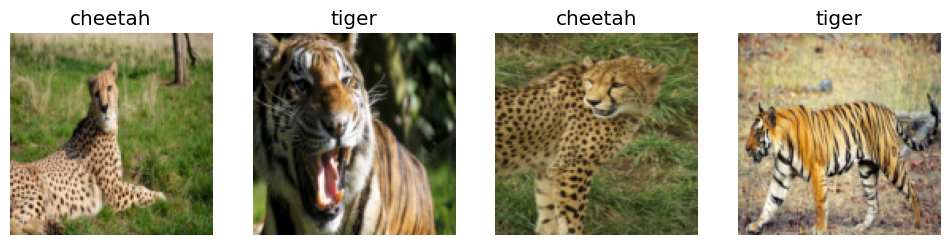

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

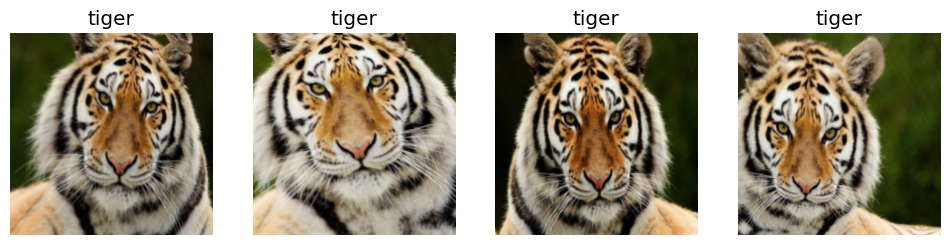

In [32]:
big_kitties = big_kitties.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),batch_tfms=aug_transforms())
dls = big_kitties.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [33]:
learn = vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.744619,0.130079,0.038874,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.184248,0.146673,0.050938,00:49
1,0.149845,0.126513,0.036193,00:50
2,0.108617,0.115050,0.029491,00:50


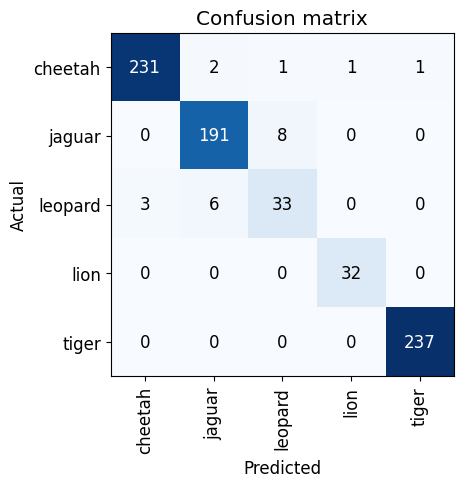

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

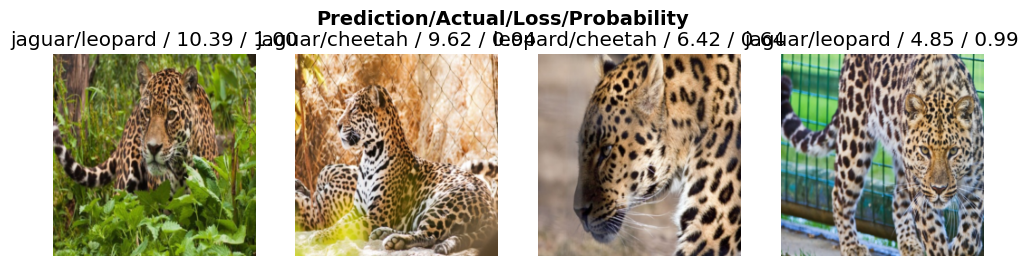

In [35]:
interp.plot_top_losses(4, nrows=1)

In [36]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]),path/cat)

In [38]:
learn.export()

In [46]:
learn_inf = load_learner(path/'export.pkl')

In [47]:
learn_inf.dls.vocab

['cheetah', 'jaguar', 'leopard', 'lion', 'tiger']

In [50]:
learn.predict('big_cats/cheetah/cheetah2.jpg')

('cheetah',
 tensor(0),
 tensor([9.9998e-01, 3.2505e-09, 1.4625e-05, 4.5439e-06, 1.6871e-11]))